In [16]:
import data_functions as dat
import importlib
import math
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import scipy.optimize as sco
import setup_analysis as sa
import time
import ri_water_model as wm
import itertools

importlib.reload(dat)


<module 'data_functions' from '/Users/jsyme/Documents/Projects/git_jbus/dmdu_scalable_computing_2022/crdm_project/python/data_functions.py'>

In [25]:
# some reloads
importlib.reload(sa)
importlib.reload(wm)

<module 'ri_water_model' from '/Users/jsyme/Documents/Projects/git_jbus/dmdu_scalable_computing_2022/crdm_project/python/ri_water_model.py'>

In [3]:
# read in input data
df_model_data = pd.read_csv(sa.fp_csv_baseline_trajectory_model_input_data)
df_climate_deltas = pd.read_csv(sa.fp_csv_climate_deltas)
df_climate_deltas_annual = pd.read_csv(sa.fp_csv_climate_deltas_annual)

In [24]:
"""
df_attribute_primary = pd.DataFrame([tuple(x) for x in itertools.product(df_strat_full["strategy_id"].unique(), df_fut["future_id"].unique())])
df_attribute_primary.rename(columns = {0: "strategy_id", 1: "future_id"}, inplace = True)
cols = list(df_attribute_primary.columns)
df_attribute_primary["primary_id"] = range(len(df_attribute_primary))
df_attribute_primary = df_attribute_primary[["primary_id"] + cols]
df_attribute_primary.to_csv("/Users/jsyme/Documents/PRGS/Classes/2021/RDM Tutorial/tutorial2021/code/workbooks_weekly/aws_demo/experimental_design/attribute_primary_id.csv", index = None, encoding = "UTF-8")
""";


## Examine default model states, parameters, and levers

In [17]:
# default dictionary of initial states
wm.md_dict_initial_states

{'reservoir_storage_million_m3': 150, 'groundwater_storage_million_m3': 14000}

In [16]:
# default dictionary of model parameters (many of which are calibrated)
wm.md_dict_parameters

{'area_catchment_km2': 4000,
 'costs_unmet_demand': [5, 1000, 1000],
 'groundwater_inflow_m3s': 5,
 'maximum_gw_discharge_m3s': 12.5,
 'maximum_reservoir_outflow_m3s': 25,
 'proportion_gw_discharge': 0.015,
 'proportion_precip_runoff': 0.3,
 'proportion_precip_infiltration': 0.7,
 'proportion_agricultural_water_runoff': 0.5}

In [7]:
#
# default single-values of levers; NOTE: the keys here can be added to df_in (df_model_data) to create a time series lever, and it will override the default
# e.g., if the reservoir increases capacity, you would add a column called "capacity_reservoir_million_m3" to df_in 
# then, you'd specify the capacity by year and month. Remember to avoid changing the default value in the model historical period
#
wm.md_dict_default_levers

{'capacity_reservoir_million_m3': 300,
 'increase_ag_efficiency_rate': 0,
 'increase_mun_efficiency_rate': 0,
 'transmission_gw_ag_m3s': nan,
 'transmission_gw_mun_m3s': 2.5,
 'transmission_res_ag_m3s': 10,
 'transmission_res_mun_m3s': 10,
 'recylcing_proportion_mun': 0.2,
 'wastewater_treatment_capacity_m3s': 0.5}

In [30]:
sa.dir_out

'/Users/jsyme/Documents/Projects/git_jbus/dmdu_scalable_computing_2022/crdm_project/out'

In [31]:
df_strat_out = df_model_data[["time_period", "year", "month"]].copy()
for k in wm.md_dict_default_levers.keys():
    df_strat_out[k] = wm.md_dict_default_levers[k]
    
df_strat_out.to_csv(os.path.join(sa.dir_out, "strategy_table_base.csv"), index = None, encoding = "UTF-8")
#wm.md_dict_default_levers

In [60]:
for k in wm.md_dict_default_levers.keys():
    if k not in df_model_data.columns:
        df_model_data[k] = wm.md_dict_default_levers[k]

## Run the model under default conditions

In [56]:
#importlib.reload(wm)
# run the model with defaults
df_out = wm.ri_water_resources_model(
    df_model_data,
    wm.md_dict_initial_states,
    dict_params,
    wm.md_dict_default_levers
)

RI model done in 7.75 seconds.


In [32]:
df_model_data.head()

,time_period,year,month,flow_m3s,precipitation_mm,population,demand_municipal_m3p,demand_agricultural_m3km2,area_ag_km2
0,1,2011,1,20.641764,14.573333,4048000,8.638743,390640.89600,150.0
1,2,2011,2,55.313316,22.716667,4052115,8.753927,416683.62240,150.0
2,3,2011,3,68.785200,22.850000,4056230,8.984293,442726.34880,150.0
3,4,2011,4,27.502083,16.800000,4060346,8.984293,458351.98464,150.0
4,5,2011,5,28.211211,40.400000,4064461,9.214660,468769.07520,150.0


In [49]:
df_out.head()

,year,month,x_11_m3,x_12_m3,x_21_m3,x_22_m3,d_1_m3,d_2_m3,d_3_m3,s_1_m3,...,r_m3,f_1_m3,f_2_m3,groundwater_storage_m3,reservoir_storage_m3,reservoir_release_m3,reservoir_spillage_m3,gw_discharge_m3,gw_recharge_m3,precip_runoff_m3
0,2011,1,5.750313e+07,6.696000e+06,0.0,2.244536e+07,5.750313e+07,2.914136e+07,100000000.0,5.750313e+07,...,47802100.0,546500.0,1339200.0,1.394611e+10,1.353777e+08,47802100.0,0.0,33480000.0,3.039340e+07,2.244293e+07
1,2011,2,6.079879e+07,6.048000e+06,0.0,2.351193e+07,6.079879e+07,2.955993e+07,100000000.0,6.079879e+07,...,41460775.0,851875.0,1209600.0,1.389579e+10,2.060165e+08,41460775.0,0.0,30240000.0,3.467266e+07,3.498367e+07
2,2011,3,3.791120e+07,3.584633e+06,26784000.0,2.678400e+07,6.469520e+07,3.036863e+07,100000000.0,6.469520e+07,...,37932175.0,856875.0,1339200.0,1.387414e+10,2.975716e+08,37932175.0,0.0,33480000.0,3.993477e+07,3.518900e+07
3,2011,4,4.157280e+07,4.479449e+06,25920000.0,2.592000e+07,6.749280e+07,3.039945e+07,100000000.0,6.749280e+07,...,46270000.0,630000.0,1296000.0,1.386122e+10,2.678319e+08,46270000.0,0.0,32400000.0,5.257817e+07,2.587200e+07
4,2011,5,4.050136e+07,6.696000e+06,26784000.0,2.451452e+07,6.728536e+07,3.121052e+07,100000000.0,6.728536e+07,...,17003800.0,1515000.0,1339200.0,1.384206e+10,2.816708e+08,17003800.0,0.0,33480000.0,4.812500e+07,6.221600e+07


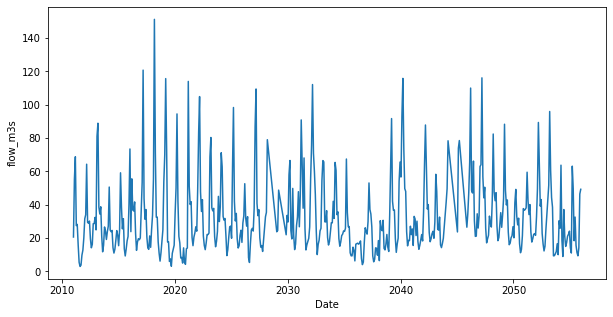

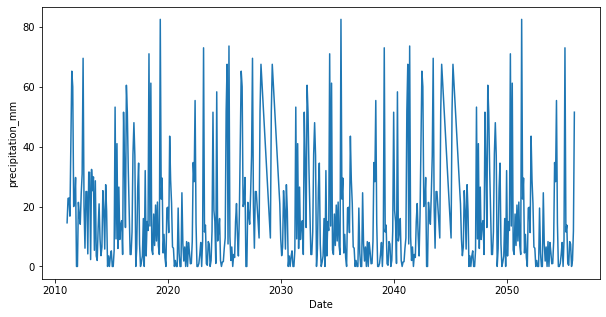

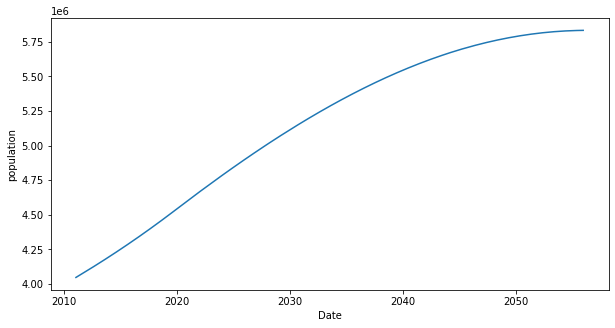

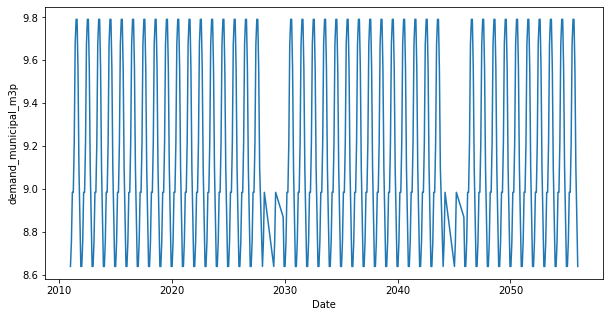

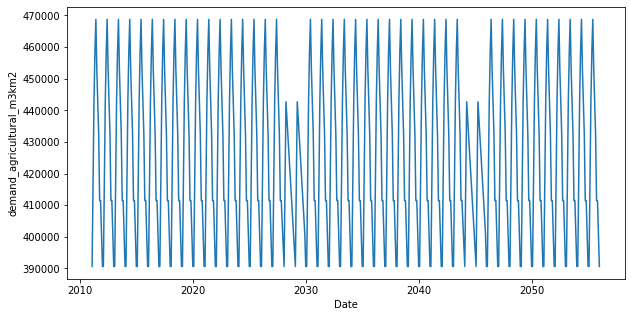

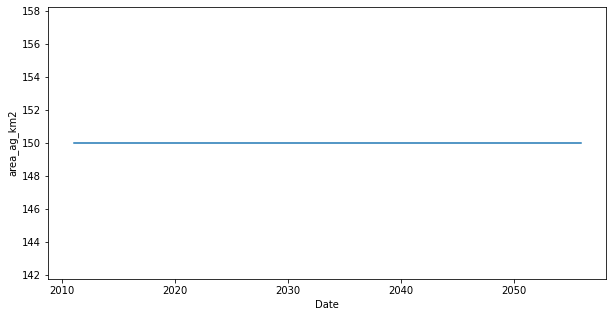

In [39]:
n = len(df_model_data)
flds_explore = [x for x in df_model_data.columns if (x not in ["year", "month", "time_period"])]

for i in flds_explore:
    x = np.array(df_model_data["year"]) + (np.array(df_model_data["month"]) - 0.5)/12
    y = np.array(df_model_data[i].iloc[0:n])
    
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.set_xlabel("Date")
    ax.set_ylabel(str(i))
    ax.plot(x, y)
    plt.show()

## Explore model output by variable

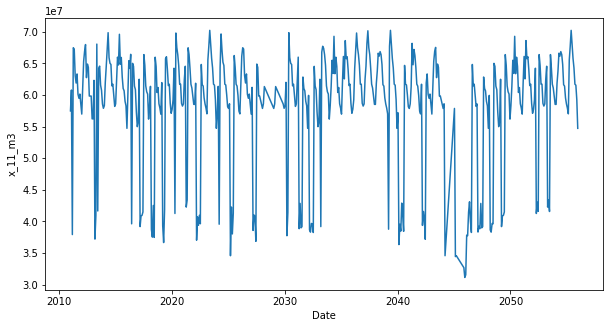

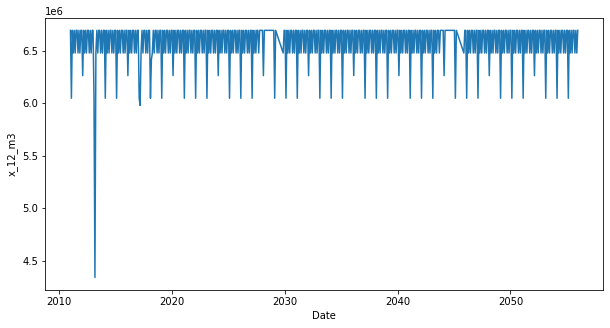

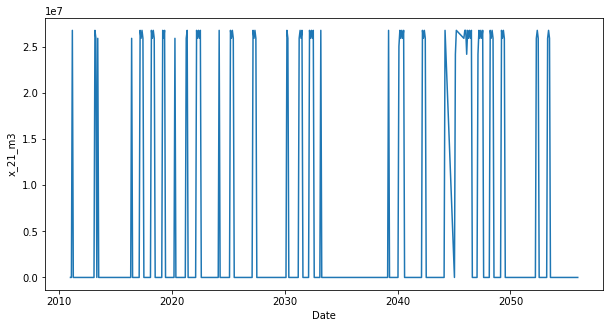

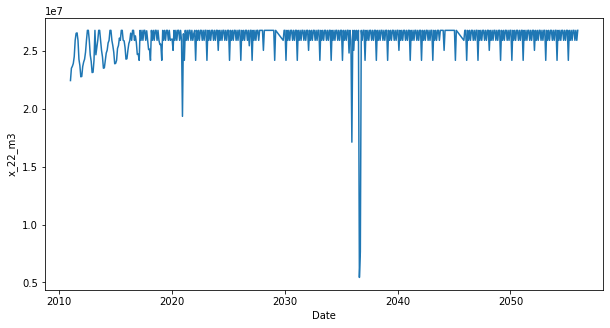

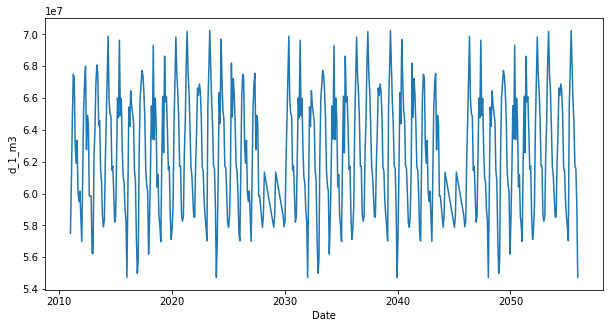

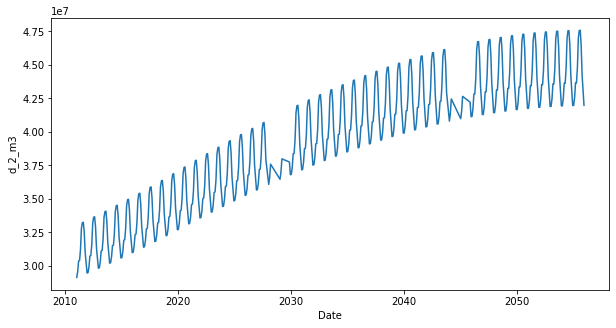

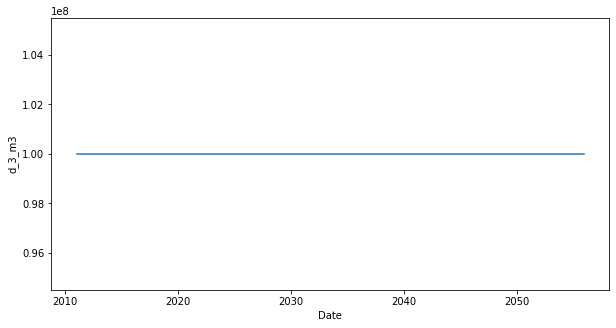

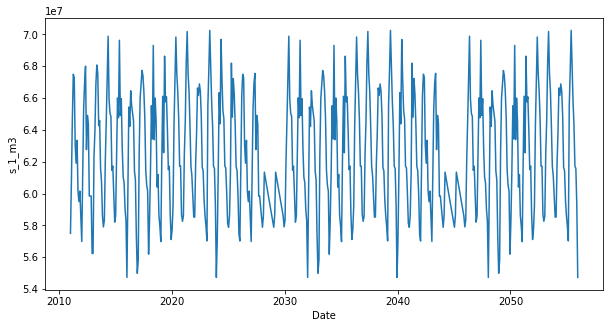

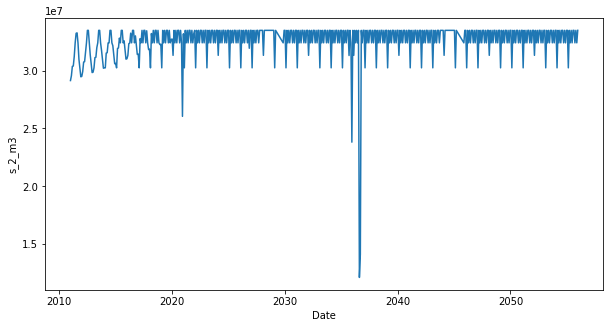

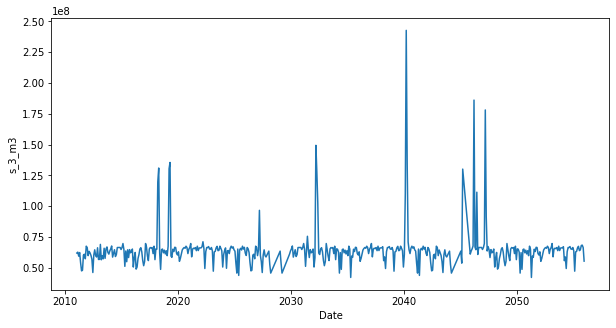

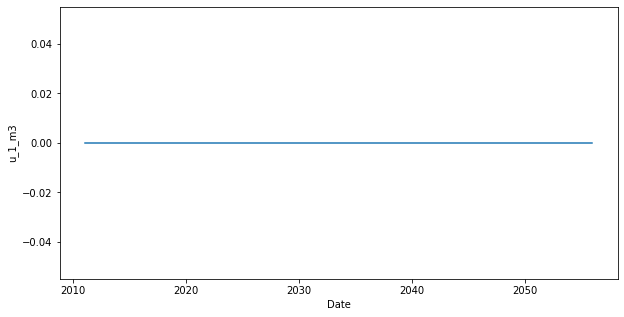

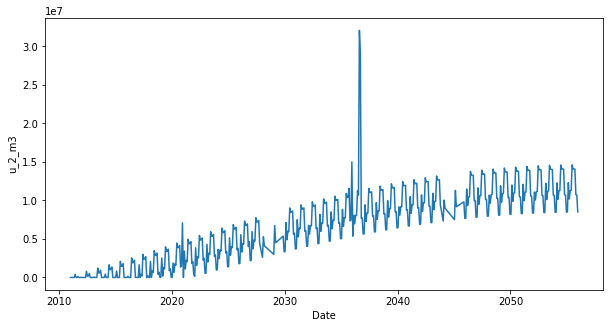

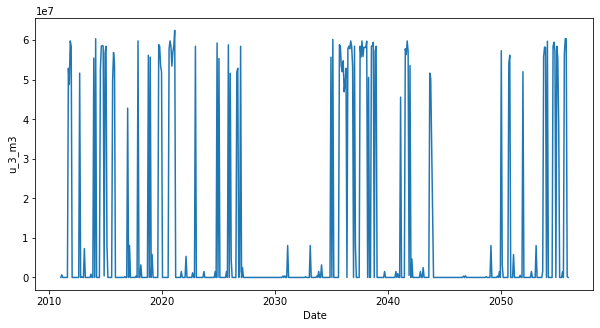

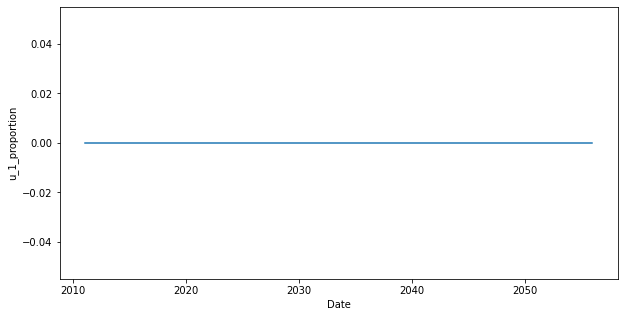

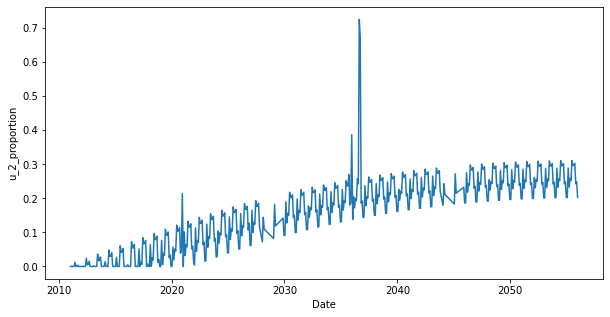

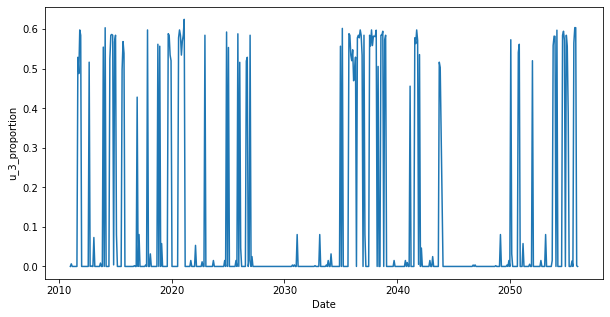

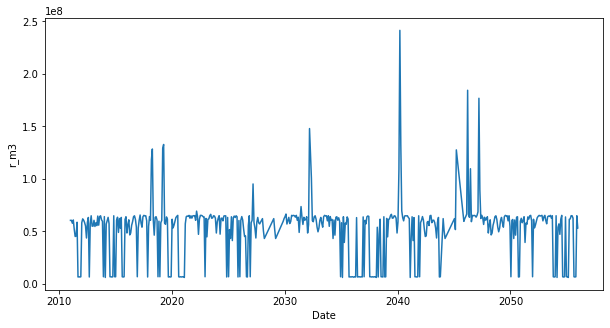

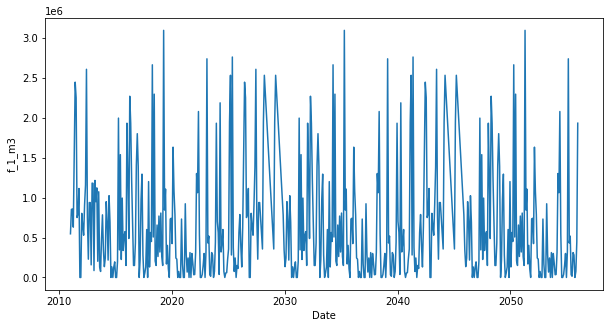

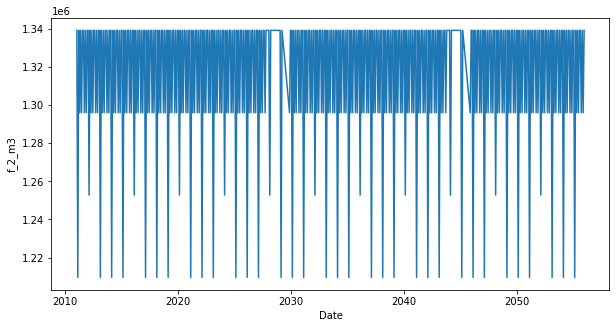

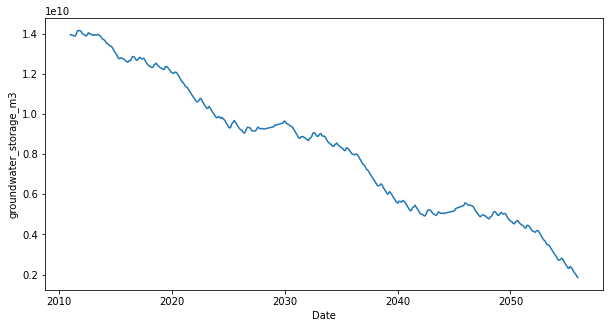

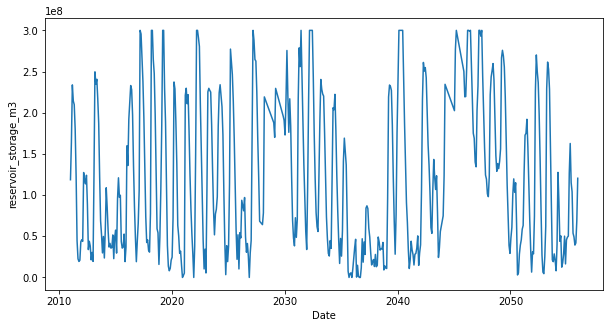

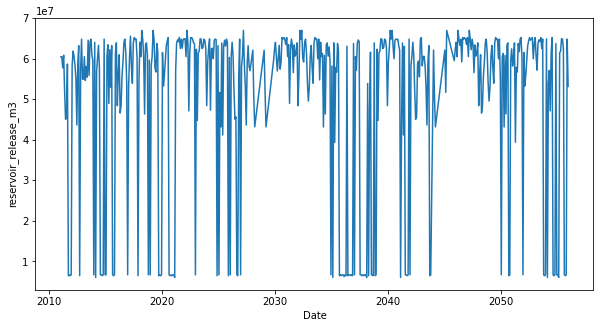

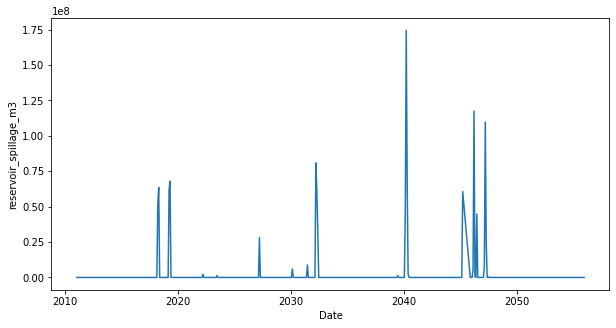

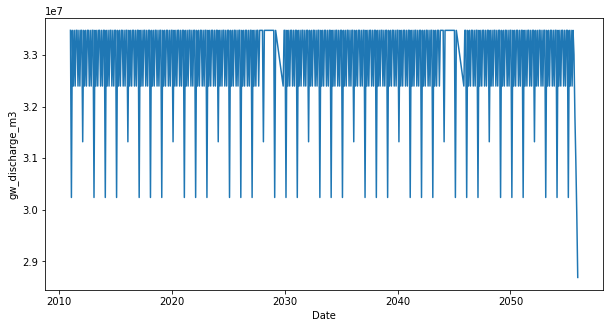

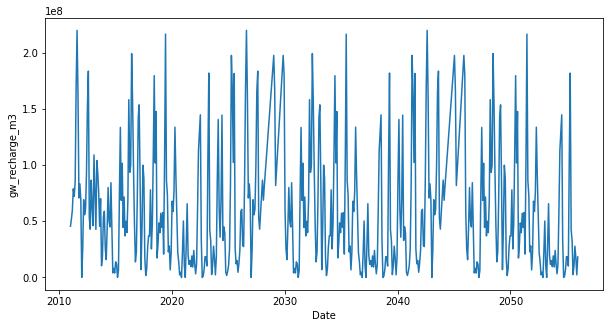

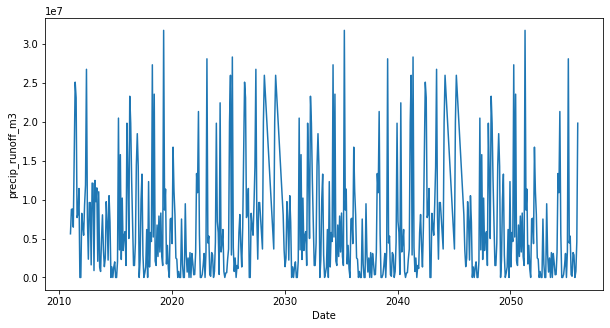

In [54]:
n = len(df_model_data)
flds_explore = [x for x in df_out.columns if (x not in ["year", "month"])]

for i in flds_explore:
    x = np.array(df_out["year"]) + (np.array(df_out["month"]) - 0.5)/12
    y = np.array(df_out[i].iloc[0:n])
    
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.set_xlabel("Date")
    ax.set_ylabel(str(i))
    ax.plot(x, y)
    plt.show()
    

##  Look at some climate data

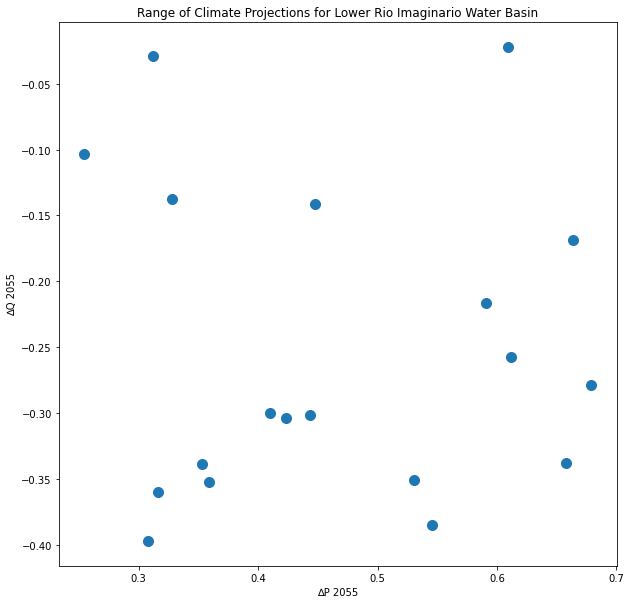

In [62]:
p = df_climate_deltas_annual["delta_p_2055_annual"]
q = df_climate_deltas_annual["delta_q_2055_annual"]
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_xlabel("∆P 2055")
ax.set_ylabel("∆Q 2055")
ax.set_title("Range of Climate Projections for Lower Rio Imaginario Water Basin")
plt.scatter(p, q, s = 100)
plt.savefig("/Users/jsyme/Documents/PRGS/Classes/2021/RDM Tutorial/tutorial2021/code/crdm_project/assignment/img/climate_scatter.jpg", dpi = 300)


In [174]:
print("\n".join(["\t- `%s`: "%(x) for x in df_out.columns]))

	- `year`: 
	- `month`: 
	- `x_11_m3`: 
	- `x_12_m3`: 
	- `x_21_m3`: 
	- `x_22_m3`: 
	- `d_1_m3`: 
	- `d_2_m3`: 
	- `d_3_m3`: 
	- `s_1_m3`: 
	- `s_2_m3`: 
	- `s_3_m3`: 
	- `u_1_m3`: 
	- `u_2_m3`: 
	- `u_3_m3`: 
	- `u_1_proportion`: 
	- `u_2_proportion`: 
	- `u_3_proportion`: 
	- `r_m3`: 
	- `f_1_m3`: 
	- `f_2_m3`: 
	- `groundwater_storage_m3`: 
	- `reservoir_storage_m3`: 
	- `reservoir_release_m3`: 
	- `reservoir_spillage_m3`: 
	- `gw_discharge_m3`: 
	- `gw_recharge_m3`: 
	- `precip_runoff_m3`: 
